## ME459 Assignment #7: Image Classification using Convolutional Neural Networks (CNNs)
---
TA : Minseok Kim 김민석 (alstjrx1x1@kaist.ac.kr)

---
## Instructions
- In this assignment, we will classify the images in CIFAR10 dataset into 10 categories (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) using Convolutional Neural Networks(CNNs).  

- In each part, you will be given a starter code for the implementation. Please read the attached illustrations and instructions carefully to implement the codes.  

- To start with, you should download this ipynb file into your own google drive.
You can save the file into your own google drive by clicking `make a copy(사본만들기)`. Find the copy in your drive, change their name to `assignment7.ipynb`, if their names were changed to e.g. `Copy of assignment7.ipyb` or `assignment7.ipynb의 사본`.


## Submission guidelines
- Your code and report will be all in Colab.
- You may download this notebook to run the code on a local machine. However, we should be able to reproduce your results on Colab using your code. Please double-check if your code runs without error and reproduces your results **on Colab**.

## Deliverables
- Download your Colab notebook file from your google drive, and submit it with name as **[StudentID].ipynb**. For example, if your student ID is 20251234, the file name should be **20251234.ipynb**.
  - **[StudentID].ipynb**: Your Colab notebook. <font color="red"> As a proof that you've ran this code by yourself, make sure your notebook contains the output of each code block. </font>
- Your assignment should be submitted through **KLMS**. All other submissions (e.g., via email) will not be considered as valid submissions.

## Due date
- **2025.06.17.**

In [1]:
import sys
def drawProgressBar(current, total, string = '', barLen = 20):
    '''
    Draws a progress bar, something like [====>    ] 20%

    Parameters
    ------------
    current: int/float
             Current progress

    total: int/float
           The total from which the current progress is made

    string: str
            Additional details to write along with progress

    barLen: int
            Length of progress bar
    '''
    percent = current/total
    arrow = ">"
    if percent == 1:
        arrow = ""
    # Carriage return, returns to the begining of line to owerwrite
    sys.stdout.write("\r")
    sys.stdout.write("Progress: [{:<{}}] {}/{}".format("=" * int(barLen * percent) + arrow,
                                                         barLen, current, total) + string)
    sys.stdout.flush()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Our first setp would be to get the training and testing dataset and apply transformations on them.

We will apply two transformations on the data: Convert images to tensors using ```transforms.ToTensor()``` and Normalize the data with mean and standard deviation of 0.5 on all dimensions using ```transforms.Normalize()```. These two transformations are combined using ```transforms.Compose()```.

Then to get the dataset, we will use the ```torchvision``` library and get the training and test data.

These datasets are converted to iterable format by using ```torch.utils.data.DataLoader``` which will divide the dataset into batches.

In [3]:
# Defining training parameters
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 16
NUM_CLASSES = 10

**About the data:**
This dataset contains 60,000 images belonging to 10 classes, with 50,000 training examples and 10,000 test examples

In [4]:
# mount drive https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab
# login with your google account and type authorization code to mount on your google drive.
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
#################################
# TODO: Modify the path to your Colab notebook file.
# {root} / assignment1.ipynb
root = '/gdrive/My Drive/Colab Notebooks'
#################################

In [6]:
# Transformations to be applied to the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])

# Getting the training and test data
# The dataset will be downloaded only once
train_data = torchvision.datasets.CIFAR10(root = root, train = True, download=True, transform = transform)
test_data = torchvision.datasets.CIFAR10(root = root, train = False, download=True, transform = transform)

# Creating iterable data loaders for train and test data
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE)

# Class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

The next step is to create a neural network architecture which will be used to train the model.  We create a class ```Net``` which has the network architecture defined.

Our network architecture is defined as follows:

Input -> Conv2d -> Relu -> MaxPool2d -> Conv2d -> Relu -> MaxPool2d -> Flatten -> Dropout -> Hidden Layer -> Output Layer

This architecture takes a 32x32 colored image as input. After a series of convolutional and max pooling layers, the image is flattened and passed to fully connected layers. The input size of fully connected layer is defined by calculating the output shape of each layer using the formula

$$W_{out} = \frac{W_{in} - F + 2P}{S} + 1$$

Where F is the kernel size, P is padding and S is stride. For max pool, the default value of stride is kernel size and for conv2d the default is 1.

# Problem 1. Implementing Classification Network (2 points)

In [7]:
# Creating a neural network architecture
class Net(nn.Module):
    '''
    Input Image size = 32x32 colored
    Number of output labels = 10
    '''
    def __init__(self):
        super(Net, self).__init__()
        #################################
        # Write your code here
        # Hint: Refer to the formula above channel size, stride and padding

        # Layer 1,
        # {
        # Conv2d : input(3, 32, 32) -> output(8, 30, 30)
        # ReLU
        # MaxPool2d : input(8, 30, 30) -> output(8, 15, 15)
        # }
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        # Layer 2,
        # {
        # Conv2d : input(8, 15, 15) -> output(16, 14, 14)
        # ReLU
        # MaxPool2d : input(16, 14, 14) -> output(16, 7, 7)
        # }
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        # fc1 input_features = 16 * 7 * 7, output_features = 256
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=256)
        # fc2 input_features = 256, output_features = 128
        self.fc2 = nn.Linear(in_features=256, out_features=128)

        #################################

        # fc3 input_features = 128, output_features = 10
        self.fc3 = nn.Linear(in_features = 128, out_features = NUM_CLASSES)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)

        x = x.view(-1, self.num_flat_features(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        n_features = 1
        for s in size:
            n_features = n_features * s

        return n_features

Next, we will define the loss function and optimizer for this model. For this problem, we choose ```nn.CrossEntropyLoss``` as our loss function. ```nn.CrossEntropyLoss``` combines ```nn.LogSoftmax()``` and ```nn.NLLLoss()``` which is why we do not have the softmax function defined in our model architecture class ```Net```.

# Problem 2. Defining Loss and Optimizer (1 points)

In [8]:
# Defining loss and optimizer
model = Net()

#################################
# Write your code here
# Use cross entropy loss
# Use Adam optimizer with pre-defined learning rate of [LEARNING_RATE]
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
#################################

Now that we have everything ready, we proceed to train the model.

There are two nested loops: one that loops over the number of epochs and another that loops over batches of data.

Steps in the inner loop:
- Enumrating over train_loader which is a sequence of batches, the batch are of the form (input, labels), so they are seperated.
- Then we run the forward pass, first get the predictions from inputs and calculate the loss using our loss function.
- Then we do back propogation. First, the gradients of optimizer are set to zero, then the gradients are calculated from the loss and we perform a step in the optimizer that updates the parameters.
- Then the accuracy is measured to get the performance of our model.

In [9]:
# Training the model

num_train_batches = len(train_loader)
loss_hist = []
acc_hist = []

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ':')

    for i, batch in enumerate(train_loader):
        # batch is a tuple of input data and labels
        inputs, labels = batch

        # Running forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measuring Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct/total

        # Printing progress
        if ((i + 1) % 10 == 0) or (i == num_train_batches - 1):
            drawProgressBar((i+1), num_train_batches,
                                  '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))

    print('\n\n')
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())

Epoch 1:
Progress: [====================] 3125/3125	 loss: 1.1999 	 acc: 0.6250


Epoch 2:
Progress: [====================] 3125/3125	 loss: 0.9697 	 acc: 0.6250


Epoch 3:
Progress: [====================] 3125/3125	 loss: 1.1858 	 acc: 0.6250


Epoch 4:
Progress: [====================] 3125/3125	 loss: 0.8215 	 acc: 0.6875


Epoch 5:
Progress: [====================] 3125/3125	 loss: 0.6293 	 acc: 0.7500


Epoch 6:
Progress: [====================] 3125/3125	 loss: 0.5646 	 acc: 0.7500


Epoch 7:
Progress: [====================] 3125/3125	 loss: 0.9166 	 acc: 0.6875


Epoch 8:
Progress: [====================] 3125/3125	 loss: 0.7004 	 acc: 0.7500


Epoch 9:
Progress: [====================] 3125/3125	 loss: 0.8197 	 acc: 0.6875


Epoch 10:
Progress: [====================] 3125/3125	 loss: 0.4505 	 acc: 0.8125




# Problem 3. Plot Train Loss and Accuracy (2 points)

Plot Example:

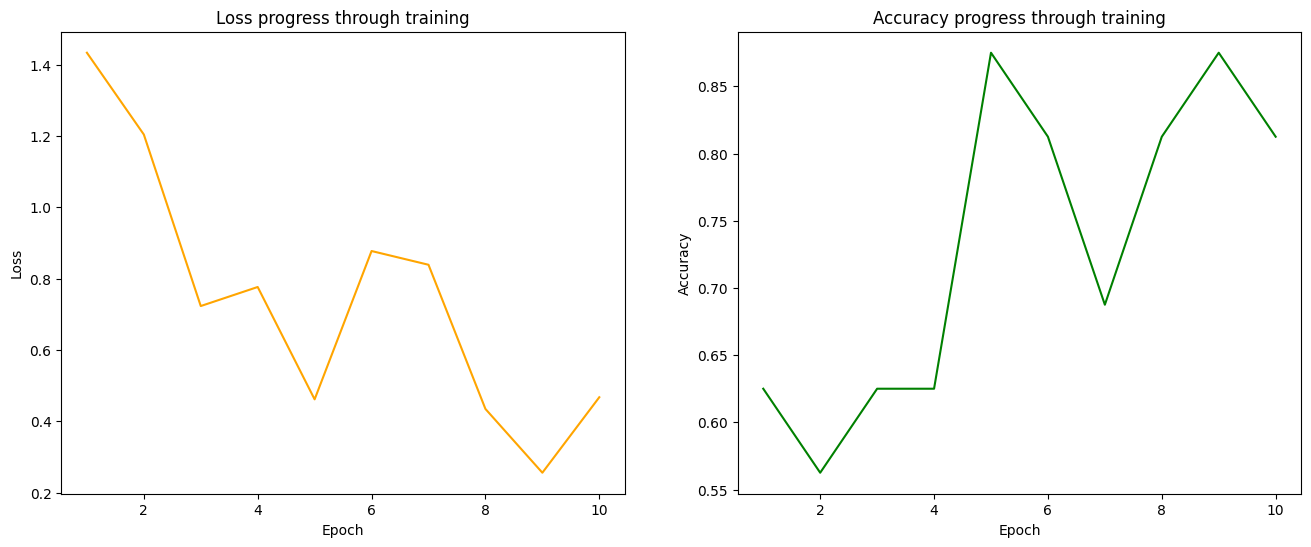

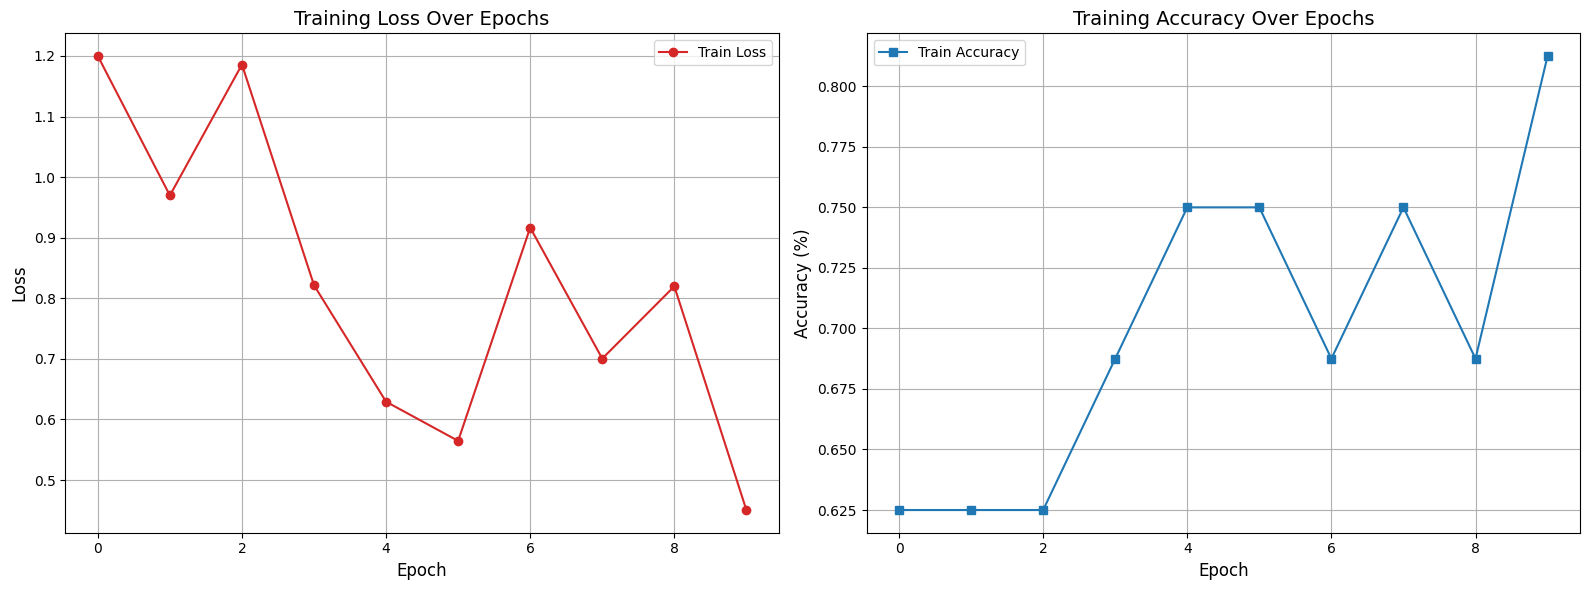

In [10]:
# Plotting the losses and accuracies
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

#################################
# Write your code here
# Plot train set accuracy history and train loss history
# Refer to the example plot above
# Loss plot
ax[0].plot(loss_hist, marker='o', color='tab:red', label='Train Loss')
ax[0].set_title('Training Loss Over Epochs', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid(True)
ax[0].legend()

# Accuracy plot
ax[1].plot(acc_hist, marker='s', color='tab:blue', label='Train Accuracy')
ax[1].set_title('Training Accuracy Over Epochs', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Accuracy (%)', fontsize=12)
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
#################################

plt.show()

Now we evalute our model on the test set.

First we put our model in evaluate mode using ```model.eval()``` so that any ```Drouput()``` or ```BatchNormalization()``` layers are removed.

Then, we use ```torch.no_grad()``` so that we temperoraly stop autograd from tracking history on Tensors and go over all batches in test set to calculate the accuracy.

In [11]:
# Testing the results
model.eval()
num_test_batches = len(test_loader)
with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Printing progress
        if ((i + 1) % 10 == 0) or (i == num_test_batches - 1):
            drawProgressBar((i+1), num_test_batches)

    print("\n\nTest accuracy: {:.4f}".format(round(correct/total, 4)))
    print("Test loss: {:.4f}".format(round(total_loss/num_test_batches, 4)))

Progress: [====================] 625/625

Test accuracy: 0.6416
Test loss: 1.2585


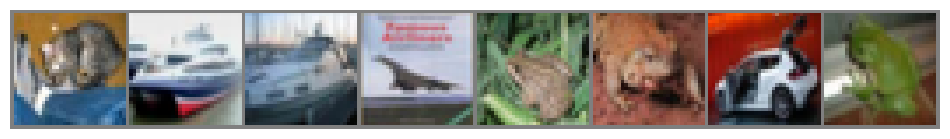

      cat      ship      ship     plane      frog      frog       car      frog		<- Actual
      cat      ship     plane     plane      frog      frog       car      frog		<- Predicted


In [12]:
# Plotting some results
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

images, labels = next(iter(test_loader))
_, predicted = torch.max(model(images), dim = 1)
plt.subplots(figsize = (12, 4))
imshow(torchvision.utils.make_grid(images[:8], padding = 1))
print(' '.join('%9s' % classes[labels[j]] for j in range(8)) + '\t\t<- Actual')
print(' '.join('%9s' % classes[predicted[j]] for j in range(8)) + '\t\t<- Predicted')

# Problem 4. Implementing Your Own Network (5 points)

(1) Build your own network.  
  You may add simple modification to the provided network. (e.g. add layer, change channel size, etc.)

(2) Train and test on the same CIFAR10 dataset.  
You may reuse the provided code.

(3) Provide test accuracy and discussions of your result.

In [34]:
import torch.nn.functional as F
import torch.nn as nn

NUM_CLASSES = 10

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3),  # (32, 30, 30)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)       # (32, 15, 15)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),  # (64, 13, 13)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)        # (64, 6, 6)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),  # (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # CrossEntropyLoss expects raw logits
        return x

In [37]:
# Train
model = CustomNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

num_train_batches = len(train_loader)
loss_hist = []
acc_hist = []

for epoch in range(EPOCHS):
    print("Epoch " + str(epoch + 1) + ':')

    for i, batch in enumerate(train_loader):
        # batch is a tuple of input data and labels
        inputs, labels = batch

        # Running forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Measuring Accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs, dim = 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct/total

        # Printing progress
        if ((i + 1) % 10 == 0) or (i == num_train_batches - 1):
            drawProgressBar((i+1), num_train_batches,
                                  '\t loss: {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))

    print('\n\n')
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())

Epoch 1:
Progress: [====================] 3125/3125	 loss: 1.0916 	 acc: 0.4375


Epoch 2:
Progress: [====================] 3125/3125	 loss: 1.7600 	 acc: 0.6875


Epoch 3:
Progress: [====================] 3125/3125	 loss: 1.2515 	 acc: 0.5625


Epoch 4:
Progress: [====================] 3125/3125	 loss: 0.5950 	 acc: 0.6250


Epoch 5:
Progress: [====================] 3125/3125	 loss: 1.2633 	 acc: 0.6250


Epoch 6:
Progress: [====================] 3125/3125	 loss: 0.6285 	 acc: 0.7500


Epoch 7:
Progress: [====================] 3125/3125	 loss: 0.9181 	 acc: 0.7500


Epoch 8:
Progress: [====================] 3125/3125	 loss: 0.7196 	 acc: 0.8125


Epoch 9:
Progress: [====================] 3125/3125	 loss: 0.4536 	 acc: 0.8750


Epoch 10:
Progress: [====================] 3125/3125	 loss: 0.4069 	 acc: 0.8125




Progress: [====================] 625/625

Test accuracy: 0.7666
Test loss: 0.7267


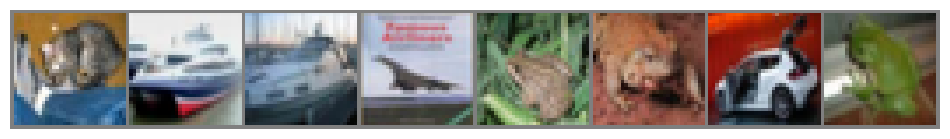

      cat      ship      ship     plane      frog      frog       car      frog		<- Actual
      cat      ship      ship     plane      frog      frog       dog      frog		<- Predicted


In [40]:
# Testing the results
model.eval()
num_test_batches = len(test_loader)
with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0
    for i, batch in enumerate(test_loader):
        inputs, labels = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Printing progress
        if ((i + 1) % 10 == 0) or (i == num_test_batches - 1):
            drawProgressBar((i+1), num_test_batches)

    print("\n\nTest accuracy: {:.4f}".format(round(correct/total, 4)))
    print("Test loss: {:.4f}".format(round(total_loss/num_test_batches, 4)))

images, labels = next(iter(test_loader))
_, predicted = torch.max(model(images), dim = 1)
plt.subplots(figsize = (12, 4))
imshow(torchvision.utils.make_grid(images[:8], padding = 1))
print(' '.join('%9s' % classes[labels[j]] for j in range(8)) + '\t\t<- Actual')
print(' '.join('%9s' % classes[predicted[j]] for j in range(8)) + '\t\t<- Predicted')

# Discussion: Write your discussion HERE
## 📘 Discussion: Performance Improvement of `CustomNet` with Adam Optimizer

In this study, we observed that the newly designed `CustomNet` architecture, when trained using the Adam optimizer with a learning rate of `1e-3` and weight decay of `1e-5`, consistently outperformed the baseline CNN model in terms of final validation accuracy. The reasons behind this improvement can be analyzed from both architectural and optimization perspectives:

---

### 1. Architectural Enhancements

#### a. Increased Representational Capacity  
The baseline network had two convolutional layers with a maximum of 16 channels, whereas `CustomNet` increases the depth and width by using three convolutional layers with up to 128 channels. This enhancement allows the model to learn more complex and abstract features, which is particularly beneficial for colored CIFAR-like datasets (32×32 RGB images).

#### b. Batch Normalization  
Each convolutional layer in `CustomNet` is followed by a `BatchNorm2d` layer. This stabilizes and accelerates training by normalizing the output distributions, reducing internal covariate shift. It also provides slight regularization, helping to improve generalization.

#### c. Dropout Regularization  
The fully connected layer is regularized with `Dropout(p=0.5)`, effectively reducing overfitting by preventing co-adaptation of neurons. This was absent in the baseline model.

#### d. Deeper Hierarchical Feature Extraction  
By adding a third convolutional layer (Conv → BN → ReLU), `CustomNet` constructs a deeper feature hierarchy, enabling it to capture fine-grained visual patterns and improving discriminative performance.

---

### 2. Improved Optimization Strategy

#### a. Adam Optimizer  
Unlike the default SGD or momentum-based methods often used in basic models, Adam (`Adaptive Moment Estimation`) adaptively tunes the learning rate for each parameter based on first and second moment estimates. This allows for:
- Faster convergence in early epochs  
- Robust training performance even with minimal manual tuning  
- Effective handling of sparse gradients and noise in deep networks  

#### b. Weight Decay Regularization  
The use of `weight_decay=1e-5` in the Adam optimizer helps penalize large weight values, effectively acting as L2 regularization. This mitigates overfitting and improves generalization.


---

In conclusion, the combination of deeper CNN design with regularization mechanisms (BatchNorm + Dropout) and a more adaptive optimization method (Adam) enables `CustomNet` to achieve improved classification performance, better generalization, and more stable training dynamics compared to the original baseline model.
